In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#some of blocks below are not used.
# Data manipulation
import numpy as np
import pandas as pd
import csv
# import vgg_pytorch as vp
# Data visualisation
import matplotlib.pyplot as plt

# Fastai
from fastai.vision import *
from fastai.vision.models import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
import torchvision.datasets as dset

from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchvision.models import *
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
#import pretrainedmodels

from pathlib import Path
import sys
import dlib
import cv2
from glob import glob
from PIL import Image




detector = dlib.get_frontal_face_detector()

np.random.seed(42)#To make sure that each time you run this kernal, you will get the same beginning parameters.

BATCH_SIZE=16
NUMBER_EPOCHS=10
IMG_SIZE=224
#pathModel ='/content/drive/My Drive/input/simple_network-Kinface2-5ClassiSpecchiato.h5'
#pathModel ='/content/drive/My Drive/input/simple_network-Kinface2-5Classi25-05.h5'
pathModel = '/content/drive/MyDrive/input/Prova1simple_network-Kinface2_12-06-No-abs.h5'
pathDir  = 'drive/MyDrive/Soliti__Ignoti/28-04-21//'

In [ ]:
def imshow(img,text=None,should_save=False):#for showing the data you loaded to dataloader
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):# for showing loss value changed with iter
    plt.plot(iteration,loss)
    plt.show()

def Trasform(lista):
  listatemp = []
  for l in lista:
      listatemp.append(labelCM[l])
  return listatemp


In [ ]:
def estrai(Dirpath):
  i = 0
  files = [file_i for file_i in os.listdir(Dirpath) if file_i.endswith("PNG")]
  for file in files:
    imgpath = Dirpath+file
    img = cv2.imread(imgpath)
    faces = detector(img, 1)
    for face_rect in faces:
        width = face_rect.right() - face_rect.left()
        height = face_rect.bottom() - face_rect.top()
        image_to_crop = Image.open(imgpath)
        crop_area = (face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom())
        cropped_image = image_to_crop.crop(crop_area)
        crop_size = (width, height)
        cropped_image.thumbnail(crop_size)
        cropped_image= cropped_image.convert('RGB')
        # cropped_image = cropped_image.resize((64,64))
        cropped_image.save(Dirpath+"ImgCropped" +str(i)+ ".jpg", "JPEG")
        i+=1

In [ ]:
class SiameseNetwork(nn.Module):# A simple implementation of siamese network, ResNet50 is used, and then connected by three fc layer.
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = vgg16(pretrained=True)# wide_resnet50_2(pretrained=True)##vp.VGG.from_pretrained('vgg16')#resnet50 doesn't work, might because pretrained model recognize all faces as the same.
        #self.ccn1.classifier =  nn.Linear(100*100, )
        # #Freeze training for all layers
        for param in self.cnn1.features.parameters():
          param.require_grad = False
        for param in self.cnn1.classifier.parameters():
          param.require_grad = False



        #Newly created modules have require_grad=True by default
        num_features = self.cnn1.classifier[3].in_features
        features = list(self.cnn1.classifier.children())[:-3] # Remove last layer
        
        self.cnn1.classifier = nn.Sequential(*features) # Replace the model classifier
        # features.extend([nn.Linear(num_features, 1000)]) # Add our layer with 4 outputs
        # features.extend([nn.ReLU(inplace=True)])
        # features.extend([nn.Dropout()]) # Add our layer with 4 outputs
        self.new_classifier = features
        # self.pool =  nn.MaxPool2d
        self.fc1 = nn.Linear(num_features*2, 1024)
        self.fc2 = nn.Linear(1024, 500)
        self.fc3 = nn.Linear(500, 5)


    def forward(self, input1, input2):#did not know how to let two resnet share the same param.
        # self.cnn1.classifier = nn.Sequential(*self.new_classifier).cuda()
        output1 = self.cnn1(input1)
        output1 = output1.view(output1.size()[0], -1)#make it suitable for fc layer.
        #output1 = F.max_pool2d(output1,kernel_size=3)
        #output1 = self.pool(2)(output1)
        #output1 = torch.cat((output1,output1),1)
        output2 = self.cnn1(input2)
        output2 = output2.view(output2.size()[0], -1)
        # output2 = self.pool(2)(output2)
        #output2 = torch.cat((output2,output2),1)
        substract_out = torch.subtract(output1,output2)
        diffal2 = torch.multiply(substract_out,substract_out)
        molt = torch.multiply(output1,output2)
        output1al2 = torch.multiply(output1,output1)
        output2al2 = torch.multiply(output2,output2)
        diffdei2 = torch.subtract(output1al2,output2al2)
        output = torch.cat((diffal2, molt),1)
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [ ]:
# estrai(pathDir)

In [ ]:
imgCropped = [i for i in os.listdir(pathDir) if i.endswith("jpg")]
lista = []
for i in range(len(imgCropped)-1):
  k = i+1
  for j in range(k,len(imgCropped)):
    lista.append([imgCropped[i],imgCropped[j],"4"])


with open(pathDir+"test.csv", 'w') as myfile:
  for p in lista:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(p)


In [ ]:
dfTest = pd.read_csv(pathDir+"test.csv",names=["p1","p2","Label"])
dfTest

In [ ]:
dfTest[(dfTest["p2"]=="ImgCropped0.jpg") &( dfTest["p1"]=="ImgCropped0.jpg")]

,p1,p2,Label
0,ImgCropped0.jpg,ImgCropped1.jpg,4


In [ ]:
dfTest["p2"][0] = 'ImgCropped0.jpg'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dfTest.to_csv(pathDir+"test.csv",index=False)
dfTest

In [ ]:
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load(pathModel))

<All keys matched successfully>

In [ ]:
class testDataset(Dataset): #different from train dataset, because the data organized in submission.csv is different from train.csv
    
    def __init__(self,path,transform=None):
        self.path = path
        self.test_df =pd.read_csv(self.path+'test.csv')
        self.transform = transform
        
    def __getitem__(self,index):
        img0_path = self.test_df.iloc[index].p1
        img1_path = self.test_df.iloc[index].p2
        label = self.test_df.iloc[index].Label
        
        img0 = Image.open(self.path+img0_path)
        img1 = Image.open(self.path+img1_path)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1,label
    
    def __len__(self):
        return len(self.test_df)

In [ ]:
testset = testDataset(path=pathDir ,transform=transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                                                      transforms.ToTensor()
                                                                      ]))
testloader = DataLoader(testset,
                        shuffle=False,
                        num_workers=8,
                        batch_size=1)#Both extra workers and batch size lead to data out of order, the submission.csv will be out of order
#if you have better method, please tell me! thanks a lot!

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
predictions=[]
lb =[]
with torch.no_grad():
    for data in testloader:
        img0, img1,label = data
        img0, img1,label = img0.cuda(), img1.cuda(),label.cuda()
        outputs = net(img0,img1)
        _, predicted = torch.max(outputs, 1)
        predictions.append(predicted.cpu().numpy())#taking care of here, the output data format is important for transfer
        lb.append(label.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
flat_list = [item for sublist in lb for item in sublist]
flat_predictions = [item for sublist in predictions for item in sublist]
correct = 0
for i in range(0,len(flat_list)):
    #print("Valore Vero:"+str(flat_list[i]))
    #print("Valore Predetto:"+str(flat_predictions[i]))
    if flat_list[i] == flat_predictions[i]:
      correct+=1
  
labelCM = ["FD", "FS","MD","MS","NK"]
  

[[ 1  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 8 17  7 12  0]]


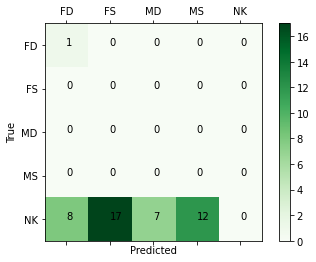

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Trasform(flat_list),Trasform(flat_predictions), labelCM)
print(cm)

fig = plt.figure()

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
for i in range(len(cm[0])):
  for j in range(len(cm[0])):
    ax.text(j, i, format(cm[i][j], "d"))
ax.set_xticklabels([''] + labelCM)
ax.set_yticklabels([''] + labelCM)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.set_cmap('Greens')
plt.show()

In [ ]:
print(cm[0][0]/(cm[0].sum()))
print(cm[1][1]/(cm[1].sum()))
print(cm[2][2]/(cm[2].sum()))
print(cm[3][3]/(cm[3].sum()))
print(cm[4][4]/(cm[4].sum()))
print(correct/8*100)

1.0
nan
nan
nan
0.0
12.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
